In [1]:
import paths
import yaml
import os
import copy
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, path as mpath, collections as mc, patches as mpatches, cm, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cklemap.sdfs.geom_mrst import GeomMRST
from cklemap.sdfs.bc_mrst import BCMRST
from cklemap.sdfs.tpfa import TPFA
from time import perf_counter
import cklemap.ckli.ckliest_h1reg as ckliest
import h5py
import GPy

In [ ]:
amps = False
if amps:
    from cklemap.sdfs.darcy import DarcyExp
    from cklemap.sdfs.dasa import DASAExpKLAMPS
    import cklemap.ckli.mapest as mapest
else:
    from cklemap.sdfs.darcy_old import DarcyExp
    from cklemap.sdfs.dasa_old import DASAExpKL
    import cklemap.ckli.mapest_old as mapest

In [2]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None, cb=False):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    if cb:
        fig.colorbar(p, ax=ax)
    return p

In [3]:
# Parameters
res_fac = 4
resolution = '4x'
ref_resolution = '16x'
num_trials = 10
seed = 0
#Nuobs = 50
NYobs = 50
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
gamma_map = 1e-6
std_dev_ref = 1.0
cor_len_ref = 0.1
Neumann_sd = 0
lsq_method = 'trf'
data_path = '../data/'
results_path = '../results/'
geom_filename = data_path + f'geom/geom_{resolution}.mat'
ref_geom_filename = data_path + f'geom/geom_{ref_resolution}.mat'
bc_filename = data_path + f'bc/bc_{resolution}.mat'
conduct_filename = data_path + f'RF2/conduct_log_RF2_{NYrefobs}_{resolution}.mat'
well_cells_filename = data_path + f'well_cells/well_cells_{resolution}.mat'
ref_yobs_filename = data_path + f'yobs/yobs_{NYobs}_{ref_resolution}.npy'
yobs_filename = data_path + f'yobs/yobs_{NYobs}_{resolution}.npy'
ref = f"Yref=RF2_{NYrefobs}_{resolution}"

In [4]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)
prob = DarcyExp(TPFA(geom, bc), None)

Nc = geom.cells.num
Ninf = geom.faces.num_interior
print(f'Ninf = {Ninf}, Nc = {Nc}')

Ninf = 11432, Nc = 5900


In [5]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]

In [6]:
# Observations
rs = npr.RandomState(seed)

# Read stochastic model from GPML output
with h5py.File(f'hanford/gpml/hanford_david_{NYrefobs}_{resolution}.mat', 'r') as f:
    Yref = f.get('mu')[:].ravel() - Yfac
    CYpred = f.get('Kp')[:]
    xrefYobs = f.get('xYobs')[:]

uref = prob.randomize_bc('N', Neumann_sd).solve(Yref)

# u observations
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1
uobs = uref[iuobs]
Nuobs = iuobs.size

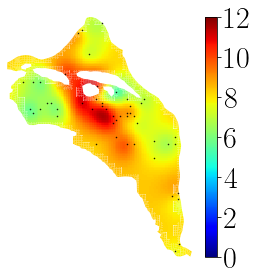

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
p = plot_patch(patches, Yref + Yfac, fig, ax, xrefYobs, 'Yref', 0, 12)
cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize='30')
cbar.locator = ticker.MaxNLocator(nbins=7)
cbar.update_ticks()
fig.tight_layout()
fig.savefig(f'hanford/figures/Yref/Yref_{ref}.pdf', dpi=300)

In [8]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [9]:
if os.path.exists(yobs_filename):
    print(f"iYobs set read from file {yobs_filename}")
    iYobs = np.load(yobs_filename)
elif os.path.exists(ref_yobs_filename):
    print(f"iYobs set read from file {ref_yobs_filename} and randomly selected nearby cell")
    iYobs_4x = np.load(ref_yobs_filename)
    geom_4x = GeomMRST(ref_geom_filename)
    iYobs = np.array([geom.anyCellsWithin(geom_4x.nodes.coords.T[geom_4x.cells.nodes.T[iYobs_4x[t]]]) for t in range(num_trials)])
    np.save(yobs_filename, iYobs)
else:
    print(f"iYobs set randomly generated and saved to {yobs_filename}")
    iYobs = np.array([np.sort(rs.choice(Nc, NYobs, replace=False)) for _ in range(num_trials)])
    np.save(yobs_filename, iYobs)
print(f"{iYobs.shape=}")
print(iYobs)

iYobs set read from file hanford_data/yobs_50_4x.npy
iYobs.shape=(10, 50)
[[ 125  218  331  592  610  767  769  925 1018 1041 1113 1208 1290 1305
  1444 1450 1507 1633 1682 1739 1784 1832 1935 1949 2118 2233 2605 2697
  3033 3044 3352 3415 3428 3537 3590 3601 4121 4127 4245 4457 4631 4751
  5122 5142 5355 5390 5410 5610 5778 5862]
 [  89  224  470  472  554  587  727  732  855  864  992 1209 1224 1244
  1411 1744 1817 1982 2135 2151 2183 2190 2194 2403 2446 2461 2575 2695
  2725 2771 2782 2879 3040 3144 3148 3211 3227 3365 3735 3873 4022 4039
  4155 4335 4345 4900 4970 5179 5292 5458]
 [   1  171  222  363  386  466  508  523  608  634  636  872 1079 1131
  1313 1359 1571 1607 1609 1936 2122 2164 2270 2284 2448 2601 2633 2862
  3024 3134 3218 3238 3720 3767 3850 3926 4014 4141 4183 4228 4336 4396
  4427 4632 4661 4776 5219 5360 5444 5778]
 [ 430  449  508  578  605  658  680 1046 1055 1118 1161 1330 1348 1375
  1621 1700 1941 2189 2230 2279 2324 2368 2483 2517 2643 2705 2739 2774
  279

In [10]:
exp = f'NY={NYobs}_Nu={iuobs.size}_{NYlearn=}_{NYxi=}_gamma={gamma_map}_cklmap_h1reg_{amps=}_{ref}'
print(exp)

NY=50_Nu=408_NYlearn=50_Nuxi=1000_NYxi=1000_beta=10.0_gamma=0.0001_Neumann_sd=0_lsq_method='trf'_hybrid_h1reg_Yref=gpml_50_4x


In [11]:
timings = np.zeros((num_trials, 6))
nfevs = np.zeros((num_trials, 3), dtype=int)
rel_errors = np.zeros((num_trials, 4))
abs_errors = np.zeros((num_trials, 4))

Yobs = np.zeros((num_trials, NYobs))
Ypred = np.zeros((num_trials, Nc))
CYpred = np.zeros((num_trials, Nc, Nc))

PsiY = np.zeros((num_trials, Nc, NYxi))
LambdaY = np.zeros((num_trials, NYxi))

Yxi = np.zeros((num_trials, NYxi))
Yest = np.zeros((num_trials, Nc))
if Neumann_sd != 0:
    Nq = np.count_nonzero(bc.kind == 'N')
    q_MAPH1 = np.zeros((num_trials, Nq))

In [12]:
for t in range(num_trials):
    iYlearn = iYobs[t]
    Ylearn = Yref[iYlearn]
    Yobs[t] = Yref[iYobs[t]]

    ts = perf_counter()
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom.cells.centroids[:, iYlearn].T, Ylearn[:,None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    print(f"{klearn.lengthscale.values[0]=}")
    print(f"{np.sqrt(klearn.variance.values[0])=}")

    mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t,:, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Ypred[t], CYpred[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    timings[t, 0] = perf_counter() - ts

print(f"GPR: {timings[:, 0]} s")

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0009   4.380966e+01   5.210432e-01 
    00s03  0012   4.379170e+01   1.276701e-05 
    00s04  0014   4.379170e+01   3.775477e-08 
Runtime:     00s04
Optimization status: Converged

klearn.lengthscale.values[0]=0.09179983937863259
np.sqrt(klearn.variance.values[0])=1.3578979508641889
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   3.901870e+01   1.410817e+02 
    00s02  0008   3.682817e+01   3.580992e+00 
    00s03  0012   3.672334e+01   6.742670e-05 
    00s04  0015   3.672334e+01   9.220884e-10 
Runtime:     00s04
Optimization status: Converged

klearn.lengthscale.values[0]=0.09212895129529186
np.sqrt(klearn.variance.values[0])=1.3368072626897594
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   3.765082e+01           nan 
    00s02  0005   3.683407e+01   9.820605

In [13]:
for t in range(num_trials):
    # Compute GP model for u
    ts = perf_counter()
    umean[t], Cu[t] = ckliest.smc_gp(Ypred[t], CYpred[t], Nens, copy.deepcopy(prob), rs, randomize_bc=True, randomize_scale=Neumann_sd)
    upred[t], Cupred[t] = ckliest.gpr(umean[t], Cu[t], uobs, iuobs)
    timings[t, 1] = perf_counter() - ts

print(f"Monte Carlo: {timings[:, 1]} s")

Monte Carlo: [132.72986986 122.85388135 125.98893258 128.15972646 125.68435444
 119.18199157 125.09162944 126.99556759 127.52533743 123.3653973 ] s


In [14]:
# PICKLE models
Ym = Ypred
CYm = CYpred
um = umean #or change to upred
Cum = Cu #or change to Cupred

rel_errors[:, 0] = np.array([rl2e(Ym[t], Yref) for t in range(num_trials)])
abs_errors[:, 0] = np.array([infe(Ym[t], Yref) for t in range(num_trials)])

print(f"GPR\tRelative error: {rel_errors[:, 0]}")
print(f"GPR\tInfinity error: {abs_errors[:, 0]}")

GPR	Relative error: [0.34702554 0.30985006 0.30462178 0.27240915 0.35299139 0.39470456
 0.2601543  0.32938105 0.28730135 0.21933901]
GPR	Infinity error: [3.79996326 2.2435658  2.45188075 2.8551064  2.18349627 3.43050669
 2.31957858 3.06481976 2.3098343  2.21457472]


In [15]:
for t in range(num_trials):
    ts = perf_counter()
    PsiY[t], LambdaY[t] = ckliest.KL_via_eigh(CYm[t], NYxi)
    timings[t, 2] = perf_counter() - ts

print(f"eigendecomposition: {timings[:, 2]} s")

eigendecomposition: [29.45869772 29.25378678 29.29409066 29.16509133 29.86798672 29.51818801
 29.58387476 29.62647319 29.68866476 29.56978405] s


In [16]:
# CKL-MAP H1 estimate
Lreg = mapest.compute_Lreg(geom)
for t in range(num_trials):
    loss = mapest.LossVec(Nc, Nc, iuobs, uobs, iYobs[t], Yobs[t], gamma_map, Lreg) # H1 regularization
    if amps:
        prob.setup_amps(iuobs)
        dasa = DASAExpKLAMPS(loss.val, loss.grad_u, loss.grad_Y, prob.partial_solve, prob.residual_sens_u, prob.residual_sens_Y, Ym[t], PsiY[t], prob.u_sens_p, (Nuobs + NYobs + Ninf, NYxi), Nuobs)
    else:
        dasa = DASAExpKL(loss.val, loss.grad_u, loss.grad_Y, prob.solve, prob.residual_sens_u, prob.residual_sens_Y, Ym[t], PsiY[t])
    ts = perf_counter()
    sol = spo.least_squares(dasa.obj, np.zeros(NYxi), jac=dasa.grad, method=lsq_method, verbose=2)
    Yest[t] = Ym[t] + PsiY[t] @ sol.x
    MAP_status = sol.status
    timings[t, 4] = perf_counter() - ts
    nfevs[t, 1] = sol.nfev
    print(f'CKLEMAP status: {MAP_status}, message: {sol.message}')

rel_errors[:, 2] = np.array([rl2e(Yest_MAPH1[t], Yref) for t in range(num_trials)])
abs_errors[:, 2] = np.array([infe(Yest_MAPH1[t], Yref) for t in range(num_trials)])

print(f"CKLEMAP: {timings[:, 4]} s")
print(f"CKLEMAP\trelative L2 error: {rel_errors[:, 2]}")
print(f"CKLEMAP\tabsolute infinity error: {abs_errors[:, 2]}")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.3455e+01                                    6.19e+01    
       1              2         1.9070e+01      5.44e+01       1.00e+00       1.52e+01    
       2              3         2.0922e+00      1.70e+01       2.00e+00       1.58e+00    
       3              4         1.8024e-01      1.91e+00       4.00e+00       4.27e-01    
       4              5         2.2791e-02      1.57e-01       8.00e+00       9.39e-01    
       5              6         6.0374e-03      1.68e-02       1.60e+01       6.26e-01    
       6              7         6.5761e-04      5.38e-03       1.60e+01       1.85e-01    
       7              8         3.9170e-04      2.66e-04       3.20e+01       1.14e-01    
       8              9         6.7912e-05      3.24e-04       1.60e+01       3.66e-03    
       9             10         6.7367e-05      5.45e-07       6.24e-01       1.42e-05    

In [17]:
np.savetxt(results_path + f'iYobs/CKLMAP/iYobs_{exp}.txt', iYobs.astype(int), fmt='%i')
np.savetxt(results_path + f'timings/CKLMAP/timings_{exp}.txt', timings)
np.savetxt(results_path + f'nfevs/CKLMAP/nfevs_{exp}.txt', nfevs.astype(int), fmt='%i')
np.savetxt(results_path + f'rel_errors/CKLMAP/rel_errors_{exp}.txt', rel_errors)
np.savetxt(results_path + f'abs_errors/CKLMAP/abs_errors_{exp}.txt', abs_errors)
np.savetxt(results_path + f'YGPR/CKLMAP/YGPR_{exp}.txt', Yref)
np.savetxt(results_path + f'YMAP/CKLMAP/YMAP_{exp}.txt', Yest)